# Importerer pakker

In [65]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
import xgboost as xgb

# Leser inn data

In [66]:
# Load pre-split data
train = pd.read_csv("../data/processed_data/train.csv")
val   = pd.read_csv("../data/processed_data/val.csv")
test= pd.read_csv("../data/processed_data/test.csv")
pred  = pd.read_csv("../data/processed_data/predict_oct2025.csv")

# Baseline modeller

In [67]:
# y_val er fasit, target_actual
y_val = val["target_actual"]

# Naiv prediksjon: bruk target_sched direkte
y_pred_baseline = val["target_sched"]

# For log loss og AUC trenger vi "sannsynligheter".
# Vi kan bruke target_sched som sannsynlighet (0 eller 1).
auc_baseline = roc_auc_score(y_val, y_pred_baseline)
eps = 1e-3  # lite justeringsledd
y_pred_proba = val["target_sched"].replace({0: eps, 1: 1-eps})

logloss_baseline = log_loss(y_val, y_pred_proba)

print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.8589835836254301
Baseline Log Loss: 0.8520113569884945


In [68]:
y_train = train["target_actual"]
p_majority = y_train.mean()  # andel positive i trening
y_pred_proba = [p_majority] * len(y_val)

logloss_baseline = log_loss(y_val, y_pred_proba)
auc_baseline = roc_auc_score(y_val, y_pred_proba)
print("Baseline AUC:", auc_baseline)
print("Baseline Log Loss:", logloss_baseline)

Baseline AUC: 0.5
Baseline Log Loss: 0.6270490498952312


# Separerer features og target og prosesserer numeriske og kategoriske variabler

In [69]:
# Define features
cat_cols = ["airport_group"]  
num_cols = [
    "flights_cnt", "avg_duration", "max_duration",
    "passenger_share", "cargo_share", "charter_share",
    "dow", "month", "hournum", "weekend",
    "target_sched", "holiday", "daily_flights_cnt",
    "flights_cnt_prev",	"flights_cnt_next"
]
feature_cols = cat_cols + num_cols

# Separate X / y
X_train = train[feature_cols]
y_train = train["target_actual"]

X_val = val[feature_cols]
y_val = val["target_actual"]

X_test = test[feature_cols]
y_test = test["target_actual"]

X_pred = pred[feature_cols]


# Preprocessing
preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])


# Random Forest

## Model

In [70]:
# Model
from scipy.stats import randint
import numpy as np
rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])

## RandomizedSearch

In [71]:
params = {
    "clf__n_estimators": randint(300, 1001),         # 300–1000
    "clf__max_depth": [None] + list(range(8, 33, 4)),# None, 8,12,16,20,24,28,32
    "clf__max_features": ["sqrt", "log2", 0.4, 0.6, 0.8],
    "clf__min_samples_split": randint(2, 21),        # 2–20
    "clf__min_samples_leaf": randint(1, 11),         # 1–10
    "clf__class_weight": [None, "balanced"],
}

tscv = TimeSeriesSplit(n_splits=4)

rs_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=params,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    n_iter=30, # Øk denne for større søk
    verbose=2,
    refit=True,
    random_state=42,
    error_score=np.nan
)
rs_rf.fit(X_train, y_train)

print("Best (Randomized) params:", rs_rf.best_params_)
print("Best CV AUC:", rs_rf.best_score_)

y_proba_val = rs_rf.best_estimator_.predict_proba(X_val)[:, 1]
print("VAL AUC:", roc_auc_score(y_val, y_proba_val))
print("VAL LogLoss:", log_loss(y_val, y_proba_val))


Fitting 4 folds for each of 30 candidates, totalling 120 fits
[CV] END clf__class_weight=None, clf__max_depth=16, clf__max_features=0.8, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=421; total time= 1.1min
[CV] END clf__class_weight=None, clf__max_depth=28, clf__max_features=0.4, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=963; total time= 1.4min
[CV] END clf__class_weight=None, clf__max_depth=24, clf__max_features=0.8, clf__min_samples_leaf=2, clf__min_samples_split=13, clf__n_estimators=713; total time= 2.0min
[CV] END clf__class_weight=None, clf__max_depth=16, clf__max_features=0.8, clf__min_samples_leaf=8, clf__min_samples_split=8, clf__n_estimators=421; total time= 2.5min
[CV] END clf__class_weight=None, clf__max_depth=28, clf__max_features=0.4, clf__min_samples_leaf=8, clf__min_samples_split=5, clf__n_estimators=963; total time= 3.1min
[CV] END clf__class_weight=balanced, clf__max_depth=8, clf__max_features=0.6, clf__min_samples_le

KeyboardInterrupt: 

## Halving Search around best params of random search

### Lager intervaller for mulig beste parametre

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV
import numpy as np

best = rs_rf.best_params_
print("Randomized best:", best)

def around_int(x, steps, lower=1):
    vals = sorted(set(int(x+s) for s in steps))
    return [v for v in vals if v >= lower]

def around_choice(x, extras):
    # legg til kandidat + noen faste gode valg
    out = list({x, *extras})
    return out

# Lite grid rundt vinneren
local_grid = {
    "clf__n_estimators":      around_int(best["clf__n_estimators"], steps=[-200, -100, 0, +100, +200], lower=50),
    "clf__max_depth":         ([None] if best["clf__max_depth"] is None 
                               else around_int(best["clf__max_depth"], steps=[-2, 0, +2], lower=2)),
    "clf__max_features":      around_choice(best["clf__max_features"], extras=["sqrt", "log2", 0.5]),
    "clf__min_samples_split": around_int(best["clf__min_samples_split"], steps=[-2, 0, +2], lower=2),
    "clf__min_samples_leaf":  around_int(best["clf__min_samples_leaf"],  steps=[-1, 0, +1], lower=1),
    "clf__class_weight":      around_choice(best["clf__class_weight"], extras=[None, "balanced"]),
}
# fjern singletons
local_grid = {k: v for k, v in local_grid.items() if len(v) > 1}
print("Local grid:", local_grid)


Randomized best: {'clf__class_weight': None, 'clf__max_depth': 28, 'clf__max_features': 0.4, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 5, 'clf__n_estimators': 963}
Local grid: {'clf__n_estimators': [763, 863, 963, 1063, 1163], 'clf__max_depth': [26, 28, 30], 'clf__max_features': [0.4, 0.5, 'log2', 'sqrt'], 'clf__min_samples_split': [3, 5, 7], 'clf__min_samples_leaf': [7, 8, 9], 'clf__class_weight': [None, 'balanced']}
n_iterations: 11
n_required_iterations: 11
n_possible_iterations: 11
min_resources_: 419
max_resources_: 429527
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1080
n_resources: 419
Fitting 4 folds for each of 1080 candidates, totalling 4320 fits
[CV] END clf__class_weight=None, clf__max_depth=26, clf__max_features=0.4, clf__min_samples_leaf=7, clf__min_samples_split=3, clf__n_estimators=763; total time=   0.7s
[CV] END clf__class_weight=None, clf__max_depth=26, clf__max_features=0.4, clf__min_samples_leaf=7, clf__min_samples_split=3, 

/opt/miniconda3/envs/avinor-ml/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END clf__class_weight=balanced, clf__max_depth=30, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=7, clf__n_estimators=763; total time=   6.0s
[CV] END clf__class_weight=balanced, clf__max_depth=26, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=5, clf__n_estimators=763; total time=  14.3s
[CV] END clf__class_weight=balanced, clf__max_depth=26, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=3, clf__n_estimators=763; total time=  22.0s
[CV] END clf__class_weight=balanced, clf__max_depth=26, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=7, clf__n_estimators=763; total time=  31.2s
[CV] END clf__class_weight=balanced, clf__max_depth=30, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=5, clf__n_estimators=763; total time=   5.4s
[CV] END clf__class_weight=balanced, clf__max_depth=30, clf__max_features=0.4, clf__min_samples_leaf=9, clf__min_samples_split=7, clf__n_est

### Utfører halving search for å finne gode parametre med opprettede intervaller

In [ ]:
hs_rf = HalvingGridSearchCV(
    estimator=rf_model,
    param_grid=local_grid,
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    verbose=2,
    refit=True,
    factor=2, # Reduser denne for grundigere søk
    resource="n_samples",
    max_resources="auto",
    random_state=42
)

hs_rf.fit(X_train, y_train)
rf_final = hs_rf.best_estimator_
print("Best (CV):", hs_rf.best_params_, "CV AUC:", hs_rf.best_score_)

# Evaluer på val
y_proba = rf_final.predict_proba(X_val)[:, 1]
print("VAL AUC:", roc_auc_score(y_val, y_proba))
print("VAL LogLoss:", log_loss(y_val, y_proba))

# Xgboost 

## Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, log_loss
import xgboost as xgb
from scipy.stats import randint, uniform, loguniform  # loguniform krever scipy >=1.4

# Pipeline (samme preprocess som før)
xgb_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",    
        random_state=42,
        n_jobs=-1
    ))
])

## Random Search

In [ ]:

# Bred fordeling for RandomizedSearch
param_dist = {
    "clf__n_estimators":      randint(300, 1501),     # 300–1500
    "clf__max_depth":         randint(3, 13),         # 3–12
    "clf__learning_rate":     loguniform(1e-3, 3e-1), # 0.001–0.3 (log-skala)
    "clf__subsample":         uniform(0.6, 0.4),      # 0.6–1.0
    "clf__colsample_bytree":  uniform(0.6, 0.4),      # 0.6–1.0
    "clf__min_child_weight":  randint(1, 11),         # 1–10
    "clf__gamma":             uniform(0.0, 5.0),      # 0–5
    "clf__reg_alpha":         loguniform(1e-8, 1e-1), # L1
    "clf__reg_lambda":        loguniform(1e-3, 10.0), # L2
}

tscv = TimeSeriesSplit(n_splits=4)

rs_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=60, # Øk denne for større søk         
    scoring="roc_auc",
    cv=tscv,                  
    n_jobs=-1,
    verbose=2,
    refit=True,
    random_state=42
)

rs_xgb.fit(X_train, y_train)

print("Best (Randomized) params:", rs_xgb.best_params_)
print("Best CV AUC:", rs_xgb.best_score_)

y_proba_val = rs_xgb.best_estimator_.predict_proba(X_val)[:, 1]
print("VAL AUC:", roc_auc_score(y_val, y_proba_val))
print("VAL LogLoss:", log_loss(y_val, y_proba_val))


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time=   1.6s
[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time=   3.2s
[CV] END clf__colsample_bytree=0.749816047538945, clf__gamma=4.75357153204958, clf__learning_rate=0.06504856968981275, clf__max_depth=7, clf__min_child_weight=7, clf__n_estimators=421, clf__reg_alpha=1.23583827723069e-07, clf__reg_lambda=0.0017073967431528124, clf__subsample=0.9464704583099741; total time= 

## Halving search around best params of random search

### Lager intervaller for mulig beste parametre

In [ ]:
best = rs_xgb.best_params_
def around_int(x, steps):
    # unike, sorterte og positive
    vals = sorted(set(int(v) for v in [x + s for s in steps] if v is not None and v > 0))
    return vals

def around_float_mul(x, factors, clip=(None, None)):
    vals = []
    for f in factors:
        v = x * f
        if clip[0] is not None: v = max(clip[0], v)
        if clip[1] is not None: v = min(clip[1], v)
        vals.append(v)
    # fjern duplikater, bevar rekkefølge
    out = []
    for v in vals:
        vv = float(v)
        if vv not in out:
            out.append(vv)
    return out

# Lag et lite nabolag for XGBoost:
grid_local = {
    "clf__n_estimators":     around_int(best["clf__n_estimators"], steps=[-200, -100, 0, +100, +200]),
    "clf__max_depth":        ([best["clf__max_depth"]] 
                              if best["clf__max_depth"] is None 
                              else around_int(best["clf__max_depth"], steps=[-2, 0, +2])),
    "clf__learning_rate":    around_float_mul(best["clf__learning_rate"], factors=[0.5, 0.75, 1.0, 1.25, 1.5],
                                              clip=(1e-3, 0.3)),
    "clf__subsample":        around_float_mul(best["clf__subsample"], factors=[0.9, 1.0, 1.1],
                                              clip=(0.6, 1.0)),
    "clf__colsample_bytree": around_float_mul(best["clf__colsample_bytree"], factors=[0.9, 1.0, 1.1],
                                              clip=(0.6, 1.0)),
    "clf__min_child_weight": around_int(best["clf__min_child_weight"], steps=[-2, -1, 0, +1, +2]),
    "clf__gamma":            around_float_mul(max(0.0, best["clf__gamma"]), factors=[0.5, 1.0, 1.5, 2.0],
                                              clip=(0.0, 5.0)),
    "clf__reg_alpha":        around_float_mul(best["clf__reg_alpha"], factors=[0.3, 0.6, 1.0, 1.5, 3.0],
                                              clip=(1e-8, 1e-1)),
    "clf__reg_lambda":       around_float_mul(best["clf__reg_lambda"], factors=[0.3, 0.6, 1.0, 1.5, 3.0],
                                              clip=(1e-3, 10.0)),
}
# Fjern nøkler med bare én verdi for å spare tid
grid_local = {k: v for k, v in grid_local.items() if len(v) > 1}
grid_local

### Utfører halving search med opprettede intervaller

In [ ]:
hs_xgb = HalvingGridSearchCV(
    estimator=xgb_model,
    param_distributions=grid_local,
    n_iter=60,                
    scoring="roc_auc",
    cv=tscv,                  
    n_jobs=-1,
    verbose=2,
    refit=True,
    random_state=42
)

hs_xgb.fit(X_train, y_train)
xgb_final = hs_xgb.best_estimator_
print("Best (CV):", hs_xgb.best_params_, "CV AUC:", hs_xgb.best_score_)

# Evaluer på val
y_proba = xgb_final.predict_proba(X_val)[:, 1]
print("VAL AUC:", roc_auc_score(y_val, y_proba))
print("VAL LogLoss:", log_loss(y_val, y_proba))


# Sammeligner modellene

In [ ]:
rf_preds = rf_final.predict(X_val)
#xgb_preds = xgb_final.predict(X_val)

y_rf_proba = rf_final.predict_proba(X_val)[:, 1]
#y_xgb_proba = xgb_final.predict_proba(X_val)[:, 1]

print("RF VAL AUC:", roc_auc_score(y_val, y_rf_proba))
#print("XGB VAL AUC:", roc_auc_score(y_val, xgb_proba))

RF VAL AUC: 0.9486853032446861


# Analyse av endelig modell

In [ ]:
y_rf_proba_test = rf_final.predict_proba(X_test)[:, 1]

print("RF TEST AUC:", roc_auc_score(y_test, y_rf_proba_test))

RF TEST AUC: 0.9637986124602145


In [ ]:
# Hent transformeren for kategoriske features
ohe = rf_final.named_steps["preprocess"].named_transformers_["cat"]

# Feature-navn for kategoriske
cat_feature_names = list(ohe.get_feature_names_out(["airport_group"]))

# Kombiner med numeriske
all_feature_names = cat_feature_names + num_cols
importances = rf_final.named_steps["clf"].feature_importances_

feat_importance = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importance.head(15))

              feature  importance
7         flights_cnt    0.355550
17       target_sched    0.234840
10    passenger_share    0.130838
9        max_duration    0.078838
8        avg_duration    0.077539
21   flights_cnt_next    0.026631
15            hournum    0.020709
19  daily_flights_cnt    0.018830
20   flights_cnt_prev    0.018397
14              month    0.015412
13                dow    0.009035
1     airport_group_B    0.002551
5     airport_group_F    0.002036
6     airport_group_G    0.002010
3     airport_group_D    0.001511


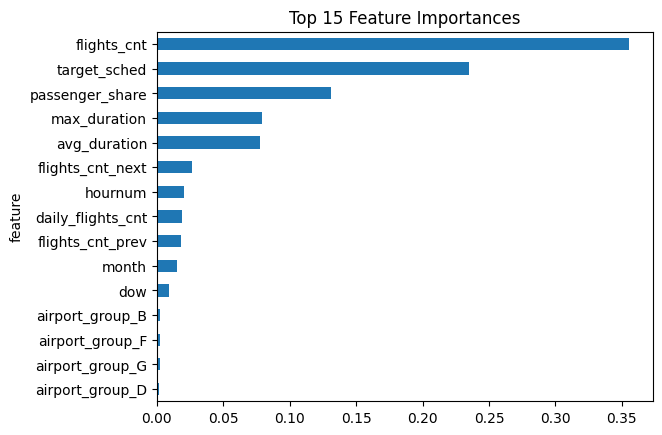

In [ ]:
import matplotlib.pyplot as plt

feat_importance.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

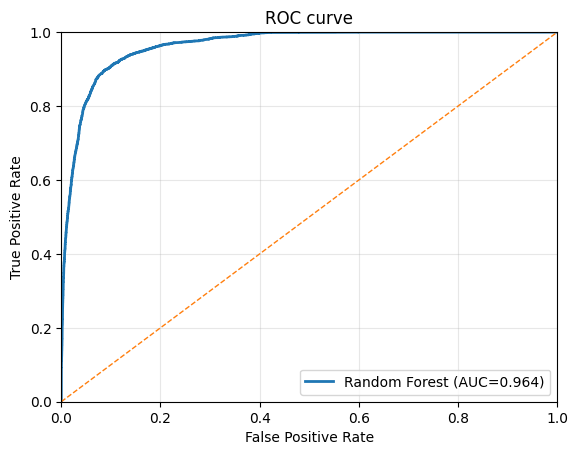

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_proba, label="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC={score:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # tilfeldig baseline
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
plot_roc(y_test, y_rf_proba_test, label="Random Forest")

# Predikerer oktober 2025 med endelig modell

In [ ]:
y_proba_oct = rf_final.predict_proba(X_pred)[:, 1]


In [ ]:
pred_out = pred.copy()
pred_out["proba_overlap"] = y_proba_oct  # sannsynlighet for overlap (target_actual=1)
pred_out["proba_overlap"] = pred_out["proba_overlap"].round(3)


pred_out["hour"] = pd.to_datetime(pred_out["hour"], errors="coerce")

pred_out = pred_out.sort_values("hour").reset_index(drop=True)

pred_out.to_csv("../data/prediction_data/predict_oct2025_with_proba.csv", index=False)

pred_out


  airport_group                hour  target_sched  flights_cnt  avg_duration  \
0             A 2025-10-01 03:00:00           1.0            2         47.50   
1             C 2025-10-01 03:00:00           NaN            0          0.00   
2             F 2025-10-01 03:00:00           NaN            0          0.00   
3             E 2025-10-01 03:00:00           1.0            2         27.50   
4             G 2025-10-01 03:00:00           1.0            4         26.25   

   max_duration  passenger_share  cargo_share  charter_share airline  dow  \
0          65.0              1.0          0.0            0.0      WF    2   
1           0.0              0.0          0.0            0.0     NaN    2   
2           0.0              0.0          0.0            0.0     NaN    2   
3          30.0              1.0          0.0            0.0      WF    2   
4          35.0              1.0          0.0            0.0      WF    2   

   holiday  month  hournum  weekend        date  flights